# Pointlike Data Format
Document the binned data format.

This format combines selected events into energy and angular bins for a given time period,  averaging over incident angles for the individual photons. We thus use the appropriate averaged PSF, and assume that the same representation is valid for the entire sky.

To measure spectra, one also needs the exposure for the event types and the same time interval. The PSF portion of the instrument response functions is also needed.

We start by describing the basic component of this photon data base, a Band. It is a container with the properties:
*    Event type, e.g., front/back
*    Energy range
*    the HEALpix _nside_ parameter, chosen so that the size of a pixel is smaller than the PSF size for that event type and energy, but otherwise arbitrary. It uses RING indexing, which allows any integer.

Then the Band contains a __sparse__ list of pairs of HEALpix indices and number of photons--only pixels with at least one photon are in the list. This property is used to make the representation effectively unbinned for energies above 1 GeV.

A full dataset is then a list of Band objects. 

## FITS file format
As an example, we load the 7-year Source class data set which was constructed from the FT1 event lists with four energy bins per decade. 

In [1]:
%matplotlib inline
from astropy.io import fits
pass8_data_path = os.path.expandvars('$FERMI/data/P8_P302')
binned_photon_data_file = os.path.join(pass8_data_path, '7years_zmax105_4bpd.fits')
hdus = fits.open(binned_photon_data_file)
hdus.info()

/afs/slac/g/glast/groups/catalog/python/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Filename: /afs/slac/g/glast/groups/catalog//pointlike/fermi/data/P8_P302/7years_zmax105_4bpd.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   ()              
1    BANDS       BinTableHDU     38   40R x 7C     [1J, 1J, 1D, 1D, 1D, 1D, 1J]   
2    PIXELS      BinTableHDU     22   13753048R x 2C   [1J, 1J]   
3    GTI         BinTableHDU     19   40304R x 2C   [D, D]   


There are three tables, labelled BANDS, PIXELS, and GTI
### The BANDS table

In [2]:
bands = pd.DataFrame(hdus[1].data)
bands[:10]['NSIDE EVENT_CLASS EMIN EMAX COUNT'.split()]

,NSIDE,EVENT_CLASS,EMIN,EMAX,COUNT
0,14,0,10.000000,17.782794,2352
1,8,1,10.000000,17.782794,768
2,22,0,17.782794,31.622777,5808
3,13,1,17.782794,31.622777,2028
4,34,0,31.622777,56.234133,13872
5,21,1,31.622777,56.234133,5292
6,54,0,56.234133,100.000000,34992
7,33,1,56.234133,100.000000,13068
8,86,0,100.000000,177.827941,88752
9,52,1,100.000000,177.827941,32448


The columns are:
* NSIDE -- HEALPix nside parameter, using RING indexing. It ranges from 8 to 8192
* EVENT_CLASS -- an index for the event type 
* EMIN, EMAX -- range of energies (MeV)
* COUNT -- the number of corresponding pixels in the PIXELS table

### The PIXELS table
This a a list of pairs of integers: (HEALPix index, photon count):

In [3]:
pixels = pd.DataFrame(hdus[2].data)
pixels[:5]

,INDEX,COUNT
0,0,208
1,1,211
2,2,178
3,3,165
4,4,155


The two columns are:
* INDEX -- HEALPix index, RING indexing, a number between 0 to $12\ x\ {nside}^2$ for the corresponding band.
* COUNT -- non-zero number of photons in the pixel.

The list is the concatenation of the data for the BANDS, in the same order. The sum of bands.COUNT must equal the length of this table.

In [4]:
assert sum(bands.COUNT)==len(pixels)
# sum counts in the BANDS

cumindex = np.asarray(bands.COUNT.cumsum(),int)
cumcount = np.asarray(pixels.COUNT.cumsum(),int)

photon_counts = []
start=0
for end in cumindex:
    photon_counts.append(cumcount[end-1]-cumcount[start])
    start = end
bands['photons'] = photon_counts
bands['pixels'] = bands.COUNT
bands['energy'] = np.sqrt(bands.EMAX * bands.EMIN)

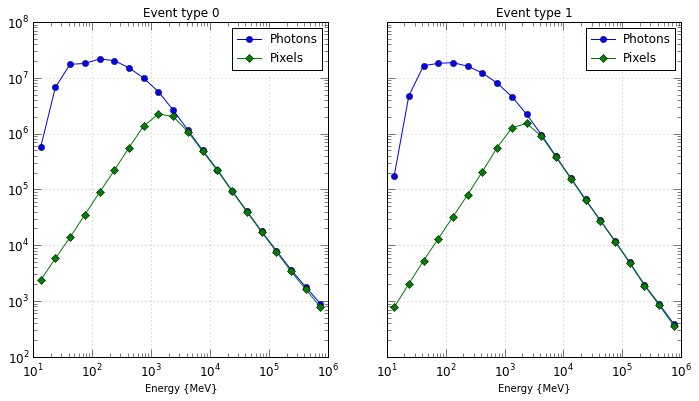

In [5]:
types = set(np.array(bands.EVENT_CLASS,int))
fig,axx=plt.subplots(1,len(types), figsize=(12,6), sharex=True, sharey=True)
for i,ax in zip(types,axx):
    et = bands.EVENT_CLASS==i
    ax.loglog(bands.energy[et], bands.photons[et],  'o-', label='Photons');
    ax.loglog(bands.energy[et], bands.pixels[et], 'D-', label='Pixels')
    ax.legend()
    ax.grid(True,alpha=0.5)
    plt.setp(ax, xlabel='Energy {MeV}', title='Event type {}'.format(i))


Note the dramatic change of the number of photons per pixel above 1 GeV, as the flux and PSF become smaller. Without a large advantage for large pixels, we effectively switch to unbinned: nside=8192, the largest value compatible with 32-bit intergers, which corresponds to 26 arcsec.

## Load the binned photon data file using C++ code
The package [`skymaps`](http://glast.stanford.edu/cgi-bin/cvsweb-SLAC/skymaps/) from the internal Science Tools package has a SWIG python interface to C++ code in it and the external pacakge `astro`. 

In [6]:
from skymaps import BinnedPhotonData as BPD
%time bpd = BPD(binned_photon_data_file)

CPU times: user 12.5 s, sys: 1.72 s, total: 14.2 s
Wall time: 14.3 s


This object is list of `skymaps.Band` objects, containing data from the BAND rows.

### Extract data for a region of interest
The `BinnedPhotonData` object does not extract anything from the PIXELS table.
Another C++ class, `skymaps.WeightedSkyDirList`, has a constructor that invokes the *query_disc* HEALPix function, to return a list of pixel positions and associated photon counts for each band. For likelihood calculations, only non-empty pixels are needed. This is important for high energies, where _nside_ is set to 8192, and only a few would have photons.

I choose as an example, a very strong, and hard high-latitude point source: Mrk 421 with Galactic coordinates (179.8317, +65.0315).

Then I plot the pixels in a 5-degree disk around the source using a pointlike tool, `image.ZEA`, which manages a ZEA projection. 

In [7]:
from skymaps import SkyDir, WeightedSkyDirList
from uw.utilities import image
center = SkyDir(179.83,65.03, SkyDir.GALACTIC)

def plot_pixels(nband, ax, ms=50):
    bpdx=bpd[nband]
    wsdl = WeightedSkyDirList(bpdx,center , np.radians(5))
    print 'Band #{}: Extracted {} photons in {} pixels'.format(nband,wsdl.counts(), wsdl.total_pix())
                                                                                 
    zea = image.ZEA(center, size=10, galactic=True,axes=ax)
    pc = np.array([zea.pixel(s) for s in wsdl])
    wt = [s.weight() for s in wsdl]
    x,y  = pc[:,0],pc[:,1]
    scat =zea.axes.scatter(x,y, c=wt, s=ms, #10000/bpdx.nside(), 
                           marker='s', edgecolor='none' )
    #cb =plt.colorbar(scat)
    #cb.set_label('Counts')
    ax.set_title('{:.0f} MeV'.format(bands.energy[nband]) );

Band #8: Extracted 23033 photons in 171 pixels
Band #16: Extracted 4475 photons in 9461 pixels
Band #24: Extracted 529 photons in 1532229 pixels


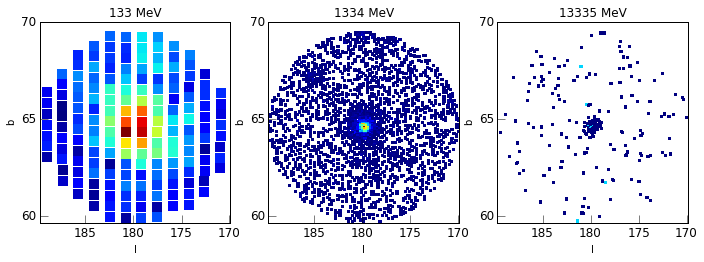

In [8]:
fig, axx = plt.subplots(1,3, figsize=(12,4))
plot_pixels(8, axx[0],100)
plot_pixels(16, axx[1], 10)
plot_pixels(24, axx[2],10)